# Computer Vision - Lab 5
- **Name:** Shy Ohev Zion
- **ID:** 318783479

## TL;DR

**This lab introduced us to:**
- the MNIST dataset and the pytorch module
- Importance of determinism and reproducibility
- conversion from numpy ndarrays to pytorch tensors and vice versa
- building classification models using previously-learned functions/concepts:
    - convolution (actually cross-correlation)
    - matrix multiplication (linear "fully connected" layers)
    - the ReLu function
    - the tanh function
    - the softmax function
    - the argmax function

**In the following report** I've built several models as said above and 'tested' each one (results were random as none of the models were trained):
- a single linear layer model
- 3 fully connected (linear) layers, with ReLu as an activation function (without it the model is equivalent to a single linear layer model)
- a simple convolution model
- the LeNet architecture, one of the earliest CNNs

## Imports, Configurations and Function Definitions (relevant for all sections)

In [1]:
import math
import torch
import numpy as np
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Lambda

Deterministic Environment Configuration and Random Generation Seed Set Up

In [2]:
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

seed = 1
np_rng = np.random.default_rng(seed)
torch.manual_seed(seed)
torch_rng_cpu = torch.Generator().manual_seed(seed)
torch_rng_gpu = torch.Generator(device="cuda").manual_seed(seed)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Printing fuction useful in all following code segments:

In [3]:
def print_output_values(model_output):
    softmax_output = F.softmax(model_output, dim=-1)
    print(f"output:\n{model_output}\n")
    print(f"output with softmax:\n{softmax_output}\n")
    print(f"sum (no softmax): {model_output.sum().item()}")
    print(f"sum (with softmax): {softmax_output.sum().item()}")
    print(f"predicted digit (no softmax): {model_output.argmax()}")
    print(f"predicted digit (with softmax): {softmax_output.argmax()}")

### importing the MNIST dataset

In [4]:
trainset = torchvision.datasets.MNIST(
    root="../data",
    train=True,
    download=True,
    transform=Compose((ToTensor(), Lambda(lambda x: x.squeeze() / 255.0))),
)

trainset_len, height, width = trainset.data.shape
num_classes = len(trainset.classes)

---
## Preparatory Work
no preparatory work was required

---
## Lab Work

Visualizing an image from the dataset

Text(0.5, 1.0, 'The Number 3')

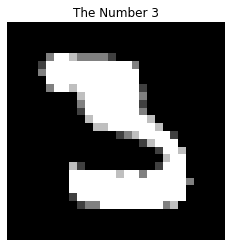

In [5]:
idx = np_rng.integers(trainset_len)
random_image, random_target = trainset[idx]
plt.imshow(random_image, cmap="gray")
plt.axis("off")
plt.title(f"The Number {random_target}")

### Implementing and Testing a Single Layer Model:

In [6]:
class Model1(nn.Module):
    def __init__(self, in_features_size, out_size):
        super().__init__()
        self.linear = nn.Linear(in_features=in_features_size, out_features=out_size)

    def forward(self, x):
        y = F.relu(self.linear(x.view(-1, math.prod(x.shape))))
        return y

In [7]:
model = Model1(height * width, num_classes)
output = model(random_image)

In [8]:
print_output_values(output.detach().cpu())

output:
tensor([[0.0305, 0.0016, 0.0274, 0.0146, 0.0000, 0.0321, 0.0013, 0.0092, 0.0000,
         0.0132]])

output with softmax:
tensor([[0.1018, 0.0989, 0.1014, 0.1002, 0.0987, 0.1019, 0.0988, 0.0996, 0.0987,
         0.1000]])

sum (no softmax): 0.1299283802509308
sum (with softmax): 1.0
predicted digit (no softmax): 5
predicted digit (with softmax): 5


---

### Implementing and Testing a 3 Layer Fully Connected Model:
- first hidden layer of size 128
- second hidden layer of size 64

In [9]:
class Model2(nn.Module):
    def __init__(self, in_features_size, out_size):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features_size, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=out_size)

    def forward(self, x):
        h1 = F.relu(self.fc1(x.view(-1, math.prod(x.shape))))
        h2 = F.relu(self.fc2(h1))
        y = F.relu(self.fc3(h2))
        return y

In [10]:
model2 = Model2(height * width, num_classes)
output = model2(random_image)
print_output_values(output.detach().cpu())

output:
tensor([[0.0000, 0.0000, 0.0000, 0.0752, 0.0331, 0.0000, 0.0137, 0.0280, 0.0000,
         0.0000]])

output with softmax:
tensor([[0.0985, 0.0985, 0.0985, 0.1062, 0.1018, 0.0985, 0.0998, 0.1013, 0.0985,
         0.0985]])

sum (no softmax): 0.14995284378528595
sum (with softmax): 1.0
predicted digit (no softmax): 3
predicted digit (with softmax): 3


---

### Implementing and Testing a Model With Convolution Layers:
- first layer is a convolution layer with 8 convolution kernels of 3x3
- second layer is a pooling layer with max-pooling kernels of 2x2 with stride 2 (meaning no intersection between pools)
- third layer is the fully connected layer, with input size of $\frac{8*(H-2)*(W-2)}{2^2}$ (where $H, W$ are the input's dimensions) and with a ReLu activation function

C

In [11]:
class Model3(nn.Module):
    def __init__(self, in_height, in_width, out_size):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear = nn.Linear(
            in_features=8 * (in_height - 2) * (in_width - 2) // (2 ** 2),
            out_features=out_size,
        )

    def forward(self, x):
        h1 = self.conv(x)
        h2 = self.pool(h1)
        y = F.relu(self.linear(h2.view(-1, math.prod(h2.shape))))
        return y

In [12]:
conv_ready_image = random_image[np.newaxis, np.newaxis, :]
model3 = Model3(height, width, num_classes)
output = model3(conv_ready_image)
print_output_values(output.detach().cpu())

output:
tensor([[0.0783, 0.0451, 0.0000, 0.0000, 0.0088, 0.0000, 0.0857, 0.0000, 0.0832,
         0.1537]])

output with softmax:
tensor([[0.1032, 0.0998, 0.0954, 0.0954, 0.0963, 0.0954, 0.1040, 0.0954, 0.1037,
         0.1113]])

sum (no softmax): 0.4546310305595398
sum (with softmax): 1.0
predicted digit (no softmax): 9
predicted digit (with softmax): 9


---
## Final Work

### Building the LeNet Architecture

In [13]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2
        )  # (6,28,28) output shape
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # (6, 14, 14)
        self.conv2 = nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5
        )  # (16, 10, 10)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # (16, 5, 5)
        self.conv3 = nn.Conv2d(
            in_channels=16, out_channels=120, kernel_size=5
        )  # (120, 1, 1)
        self.fc1 = nn.Linear(in_features=120, out_features=84)  # (80)
        self.fc2 = nn.Linear(in_features=84, out_features=10)  # (10)

    def forward(self, x):
        h1 = self.conv1(x).tanh()
        h2 = self.pool1(h1)
        h3 = self.conv2(h2).tanh()
        h4 = self.pool2(h3)
        h5 = self.conv3(h4).tanh()
        h6 = self.fc1(h5.view(-1, math.prod(h5.shape))).tanh()
        y = self.fc2(h6)
        return y

In [14]:
lenet_model = LeNet()
output = lenet_model(conv_ready_image)
print_output_values(output.detach().cpu())

output:
tensor([[-0.1041,  0.0088, -0.0528,  0.0469, -0.0183, -0.0684, -0.0887,  0.0995,
         -0.0178,  0.0511]])

output with softmax:
tensor([[0.0912, 0.1021, 0.0960, 0.1061, 0.0994, 0.0946, 0.0926, 0.1118, 0.0995,
         0.1066]])

sum (no softmax): -0.14386633038520813
sum (with softmax): 0.9999999403953552
predicted digit (no softmax): 7
predicted digit (with softmax): 7
